## 1. Darwin's bibliography
<p><img src="https://assets.datacamp.com/production/project_607/img/CharlesDarwin.jpg" alt="Charles Darwin" width="300px"></p>
<p>Charles Darwin is one of the few universal figures of science. His most renowned work is without a doubt his "<em>On the Origin of Species</em>" published in 1859 which introduced the concept of natural selection. But Darwin wrote many other books on a wide range of topics, including geology, plants or his personal life. In this notebook, we will automatically detect how closely related his books are to each other.</p>
<p>To this purpose, we will develop the bases of <strong>a content-based book recommendation system</strong>, which will determine which books are close to each other based on how similar the discussed topics are. The methods we will use are commonly used in text- or documents-heavy industries such as legal, tech or customer support to perform some common task such as text classification or handling search engine queries.</p>
<p>Let's take a look at the books we'll use in our recommendation system.</p>

In [1]:
import glob
folder = "datasets/"
files = sorted(list(glob.glob('datasets/*.txt')))
files

['datasets/Autobiography.txt',
 'datasets/CoralReefs.txt',
 'datasets/DescentofMan.txt',
 'datasets/DifferentFormsofFlowers.txt',
 'datasets/EffectsCrossSelfFertilization.txt',
 'datasets/ExpressionofEmotionManAnimals.txt',
 'datasets/FormationVegetableMould.txt',
 'datasets/FoundationsOriginofSpecies.txt',
 'datasets/GeologicalObservationsSouthAmerica.txt',
 'datasets/InsectivorousPlants.txt',
 'datasets/LifeandLettersVol1.txt',
 'datasets/LifeandLettersVol2.txt',
 'datasets/MonographCirripedia.txt',
 'datasets/MonographCirripediaVol2.txt',
 'datasets/MovementClimbingPlants.txt',
 'datasets/OriginofSpecies.txt',
 'datasets/PowerMovementPlants.txt',
 'datasets/VariationPlantsAnimalsDomestication.txt',
 'datasets/VolcanicIslands.txt',
 'datasets/VoyageBeagle.txt']

## 2. Load the contents of each book into Python
<p>As a first step, we need to load the content of these books into Python and do some basic pre-processing to facilitate the downstream analyses. We call such a collection of texts <strong>a corpus</strong>. We will also store the titles for these books for future reference and print their respective length to get a gauge for their contents.</p>

In [2]:
import re, os
txts = []
titles = []
for n in files:
    f = open(n, encoding='utf-8-sig')
    # Remove all non-alpha-numeric characters
    data = re.sub( '[\W_]+',' ',f.read() )
    # Store the texts and titles of the books in two separate lists
    txts.append(data)
    titles.append(os.path.basename(n).replace('.txt', ''))

# Print the length, in characters, of each book
[len(t) for t in txts]

[123231,
 496068,
 1776539,
 617088,
 913713,
 624232,
 335920,
 523021,
 797401,
 901406,
 1047518,
 1010643,
 767492,
 1660866,
 298319,
 916267,
 1093567,
 1043499,
 341447,
 1149574]

## 3. Find "On the Origin of Species"
<p>For the next parts of this analysis, we will often check the results returned by our method for a given book. For consistency, we will refer to Darwin's most famous book: "<em>On the Origin of Species</em>." Let's find to which index this book is associated.</p>

In [3]:
for i in range(len(titles)):
    if titles[i]=="OriginofSpecies":
        ori = i
print(ori)

15


## 4. Tokenize the corpus
<p>As a next step, we need to transform the corpus into a format that is easier to deal with for the downstream analyses. We will tokenize our corpus, i.e., transform each text into a list of the individual words (called tokens) it is made of. To check the output of our process, we will print the first 20 tokens of "<em>On the Origin of Species</em>".</p>

In [4]:
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())
txts_lower_case = [txt.lower() for txt in txts]
# Transform the text into tokens 
txts_split = [txt.split() for txt in txts_lower_case]
# Remove tokens which are part of the list of stop words
texts = [[word for word in txt if word not in stoplist] for txt in txts_split]
# Print the first 20 tokens for the "On the Origin of Species" book
texts[ori][0:20]

['on',
 'origin',
 'species',
 'but',
 'with',
 'regard',
 'material',
 'world',
 'can',
 'least',
 'go',
 'so',
 'far',
 'this',
 'can',
 'perceive',
 'events',
 'are',
 'brought',
 'about']

## 5. Stemming of the tokenized corpus
<p>If you have read <em>On the Origin of Species</em>, you will have noticed that Charles Darwin can use different words to refer to a similar concept. For example, the concept of selection can be described by words such as <em>selection</em>, <em>selective</em>, <em>select</em> or <em>selects</em>. This will dilute the weight given to this concept in the book and potentially bias the results of the analysis.</p>
<p>To solve this issue, it is a common practice to use a <strong>stemming process</strong>, which will group together the inflected forms of a word so they can be analysed as a single item: <strong>the stem</strong>. In our <em>On the Origin of Species</em> example, the words related to the concept of selection would be gathered under the <em>select</em> stem.</p>
<p>As we are analysing 20 full books, the stemming algorithm can take several minutes to run and, in order to make the process faster, we will directly load the final results from a pickle file and review the method used to generate it.</p>

In [5]:
import pickle
# Load the stemmed tokens list from the pregenerated pickle file
texts_stem = pickle.load(open('datasets/texts_stem.p', 'rb'))
# Print the 20 first stemmed tokens from the "On the Origin of Species" book
texts_stem[ori][0:20]

['on',
 'origin',
 'speci',
 'but',
 'with',
 'regard',
 'materi',
 'world',
 'can',
 'least',
 'go',
 'so',
 'far',
 'thi',
 'can',
 'perceiv',
 'event',
 'are',
 'brought',
 'about']

## 6. Building a bag-of-words model
<p>Now that we have transformed the texts into stemmed tokens, we need to build models that will be useable by downstream algorithms.</p>
<p>First, we need to will create a universe of all words contained in our corpus of Charles Darwin's books, which we call <em>a dictionary</em>. Then, using the stemmed tokens and the dictionary, we will create <strong>bag-of-words models</strong> (BoW) of each of our texts. The BoW models will represent our books as a list of all uniques tokens they contain associated with their respective number of occurrences. </p>
<p>To better understand the structure of such a model, we will print the five first elements of one of the "<em>On the Origin of Species</em>" BoW model.</p>

In [6]:
from gensim import corpora
# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)
# Create a bag-of-words model for each book, using the previously generated dictionary
bows = [dictionary.doc2bow(text) for text in texts_stem]
# Print the first five elements of the On the Origin of species' BoW model
bows[ori][0:5]

[(0, 11), (5, 51), (6, 1), (8, 2), (21, 1)]

## 7. The most common words of a given book
<p>The results returned by the bag-of-words model is certainly easy to use for a computer but hard to interpret for a human. It is not straightforward to understand which stemmed tokens are present in a given book from Charles Darwin, and how many occurrences we can find.</p>
<p>In order to better understand how the model has been generated and visualize its content, we will transform it into a DataFrame and display the 10 most common stems for the book "<em>On the Origin of Species</em>".</p>

In [7]:
import pandas as pd
# Convert the BoW model for "On the Origin of Species" into a DataFrame
df_bow_origin = pd.DataFrame(bows[ori])
# Add the column names to the DataFrame
df_bow_origin.columns = ['index', 'occurrences']
# Add a column containing the token corresponding to the dictionary index
df_bow_origin['token']= [dictionary[index] for index in df_bow_origin["index"]]
# Sort the DataFrame by descending number of occurrences and print the first 10 values
df_bow_origin.sort_values(by='occurrences', ascending=False).head(10)

,index,occurrences,token
748,1168,2023,have
1119,1736,1558,on
1489,2288,1543,speci
892,1366,1480,it
239,393,1362,by
1128,1747,1201,or
125,218,1140,are
665,1043,1137,from
1774,2703,1000,with
1609,2452,962,thi


## 8. Build a tf-idf model
<p>If it wasn't for the presence of the stem "<em>speci</em>", we would have a hard time to guess this BoW model comes from the <em>On the Origin of Species</em> book. The most recurring words are, apart from few exceptions, very common and unlikely to carry any information peculiar to the given book. We need to use an additional step in order to determine which tokens are the most specific to a book.</p>
<p>To do so, we will use a <strong>tf-idf model</strong> (term frequency–inverse document frequency). This model defines the importance of each word depending on how frequent it is in this text and how infrequent it is in all the other documents. As a result, a high tf-idf score for a word will indicate that this word is specific to this text.</p>
<p>After computing those scores, we will print the 10 words most specific to the "<em>On the Origin of Species</em>" book (i.e., the 10 words with the highest tf-idf score).</p>

In [8]:
from gensim.models import TfidfModel
model = TfidfModel(bows)
# Print the model for "On the Origin of Species"
print(model[bows[ori]])

[(8, 0.00020383224047642202), (21, 0.0005716037746542094), (23, 0.0017118699041370883), (27, 0.0006458270601429994), (28, 0.0025678048562056324), (31, 0.0008559349520685442), (35, 0.00101497410751472), (36, 0.00101497410751472), (51, 0.000886740665721021), (54, 0.00202994821502944), (56, 0.0023757190244598344), (57, 0.00010191612023821101), (63, 0.0027544680933525786), (64, 0.000509580601191055), (66, 0.00020383224047642202), (67, 0.0023757190244598344), (68, 0.00202994821502944), (75, 0.0013772340466762893), (76, 0.0004433703328605105), (78, 0.004171843479607349), (80, 0.0020859217398036746), (83, 0.00857405661981314), (84, 0.000509580601191055), (88, 0.002445986885717064), (89, 0.0033632319678609636), (90, 0.000886740665721021), (91, 0.0016747506839411234), (94, 0.000886740665721021), (95, 0.0004433703328605105), (96, 0.003546962662884084), (97, 0.0016306579238113761), (102, 0.037686478293143394), (104, 0.000917245082143899), (106, 0.001417375386254771), (108, 0.0035434384656369273),

## 9. The results of the tf-idf model
<p>Once again, the format of those results is hard to interpret for a human. Therefore, we will transform it into a more readable version and display the 10 most specific words for the "<em>On the Origin of Species</em>" book.</p>

In [9]:
# Convert the tf-idf model for "On the Origin of Species" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[ori]])
df_tfidf.columns=['id', 'score']
# Add the tokens corresponding to the numerical indices for better readability
df_tfidf['token']= [dictionary[index] for index in list(df_tfidf["id"])]
# Sort the DataFrame by descending tf-idf score and print the first 10 rows.
df_tfidf.sort_values(by='score', ascending=False).head(10)

,id,score,token
878,2164,0.327414,select
3106,10108,0.203908,pigeon
128,369,0.197721,breed
2988,9396,0.167496,migrat
945,2325,0.148186,steril
284,752,0.145990,domest
503,1255,0.128272,hybrid
370,966,0.127534,fertil
3889,16210,0.124392,rtner
3540,12715,0.121197,naturalis


## 10. Compute distance between texts
<p>The results of the tf-idf algorithm now return stemmed tokens which are specific to each book. We can, for example, see that topics such as selection, breeding or domestication are defining "<em>On the Origin of Species</em>" (and yes, in this book, Charles Darwin talks quite a lot about pigeons too). Now that we have a model associating tokens to how specific they are to each book, we can measure how related to books are between each other.</p>
<p>To this purpose, we will use a measure of similarity called <strong>cosine similarity</strong> and we will visualize the results as a distance matrix, i.e., a matrix showing all pairwise distances between Darwin's books.</p>

In [10]:
from gensim import similarities

# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])
sim_df = pd.DataFrame(list(sims))
sim_df.columns=titles
sim_df.index = titles
sim_df

,Autobiography,CoralReefs,DescentofMan,DifferentFormsofFlowers,EffectsCrossSelfFertilization,ExpressionofEmotionManAnimals,FormationVegetableMould,FoundationsOriginofSpecies,GeologicalObservationsSouthAmerica,InsectivorousPlants,LifeandLettersVol1,LifeandLettersVol2,MonographCirripedia,MonographCirripediaVol2,MovementClimbingPlants,OriginofSpecies,PowerMovementPlants,VariationPlantsAnimalsDomestication,VolcanicIslands,VoyageBeagle
Autobiography,1.000000,0.049467,0.080428,0.066482,0.077184,0.088723,0.040678,0.059271,0.030562,0.014878,0.396709,0.217129,0.005686,0.008483,0.022856,0.099991,0.016247,0.049018,0.038556,0.183507
CoralReefs,0.049467,1.000000,0.009480,0.001952,0.001923,0.004999,0.029432,0.022096,0.061027,0.002276,0.030965,0.017558,0.006324,0.010579,0.001518,0.039089,0.002707,0.011586,0.057514,0.267749
DescentofMan,0.080428,0.009480,1.000000,0.072761,0.029968,0.148670,0.027055,0.135775,0.009698,0.009404,0.059684,0.080314,0.053506,0.043275,0.005146,0.267554,0.011357,0.232841,0.007882,0.123917
DifferentFormsofFlowers,0.066482,0.001952,0.072761,1.000000,0.391834,0.006474,0.010585,0.040104,0.002846,0.007502,0.015933,0.046523,0.009405,0.005484,0.008151,0.128909,0.018964,0.050023,0.002611,0.013124
EffectsCrossSelfFertilization,0.077184,0.001923,0.029968,0.391834,1.000000,0.006844,0.032262,0.040288,0.002246,0.006777,0.019504,0.046504,0.003212,0.002962,0.014932,0.146441,0.039770,0.055132,0.002178,0.017140
ExpressionofEmotionManAnimals,0.088723,0.004999,0.148670,0.006474,0.006844,1.000000,0.020985,0.047202,0.005217,0.011475,0.064873,0.048886,0.016825,0.029897,0.005913,0.062979,0.011317,0.083847,0.005561,0.098961
FormationVegetableMould,0.040678,0.029432,0.027055,0.010585,0.032262,0.020985,1.000000,0.021470,0.067989,0.035589,0.027916,0.023620,0.019866,0.023984,0.038820,0.049259,0.040182,0.033147,0.059407,0.097908
FoundationsOriginofSpecies,0.059271,0.022096,0.135775,0.040104,0.040288,0.047202,0.021470,1.000000,0.028028,0.006023,0.057820,0.054782,0.007618,0.010883,0.003973,0.322405,0.008788,0.194533,0.017590,0.089132
GeologicalObservationsSouthAmerica,0.030562,0.061027,0.009698,0.002846,0.002246,0.005217,0.067989,0.028028,1.000000,0.006879,0.028551,0.012104,0.009687,0.024738,0.002043,0.058046,0.003491,0.014389,0.373249,0.260141
InsectivorousPlants,0.014878,0.002276,0.009404,0.007502,0.006777,0.011475,0.035589,0.006023,0.006879,1.000000,0.005967,0.016518,0.019214,0.020023,0.249814,0.014961,0.023056,0.010522,0.008544,0.014776


## 11. The book most similar to "On the Origin of Species"
<p>We now have a matrix containing all the similarity measures between any pair of books from Charles Darwin! We can now use this matrix to quickly extract the information we need, i.e., the distance between one book and one or several others. </p>
<p>As a first step, we will display which books are the most similar to "<em>On the Origin of Species</em>," more specifically we will produce a bar chart showing all books ranked by how similar they are to Darwin's landmark work.</p>

Text(0.5, 1.0, 'The most silmilar')

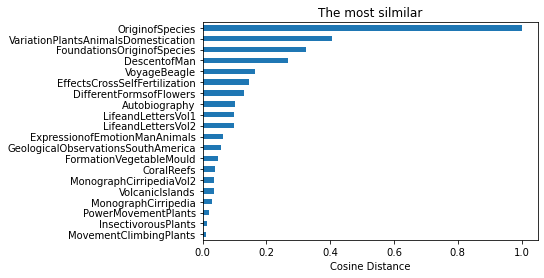

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
# Select the column corresponding to "On the Origin of Species" and 
v = sim_df['OriginofSpecies']
# Sort by ascending scores
v_sorted = v.sort_values( ascending=True)
# Plot this data has a horizontal bar plot
v_sorted.plot.barh(x='lab', y='val', rot=0).plot()
# Modify the axes labels and plot title for a better readability
plt.xlabel('Cosine Distance')
plt.ylabel('')
plt.title("The most silmilar")

## 12. Which books have similar content?
<p>This turns out to be extremely useful if we want to determine a given book's most similar work. For example, we have just seen that if you enjoyed "<em>On the Origin of Species</em>," you can read books discussing similar concepts such as "<em>The Variation of Animals and Plants under Domestication</em>" or "<em>The Descent of Man, and Selection in Relation to Sex</em>." If you are familiar with Darwin's work, these suggestions will likely seem natural to you. Indeed, <em>On the Origin of Species</em> has a whole chapter about domestication and <em>The Descent of Man, and Selection in Relation to Sex</em> applies the theory of natural selection to human evolution. Hence, the results make sense.</p>
<p>However, we now want to have a better understanding of the big picture and see how Darwin's books are generally related to each other (in terms of topics discussed). To this purpose, we will represent the whole similarity matrix as a dendrogram, which is a standard tool to display such data. <strong>This last approach will display all the information about book similarities at once.</strong> For example, we can find a book's closest relative but, also, we can visualize which groups of books have similar topics (e.g., the cluster about Charles Darwin personal life with his autobiography and letters). If you are familiar with Darwin's bibliography, the results should not surprise you too much, which indicates the method gives good results. Otherwise, next time you read one of the author's book, you will know which other books to read next in order to learn more about the topics it addressed.</p>

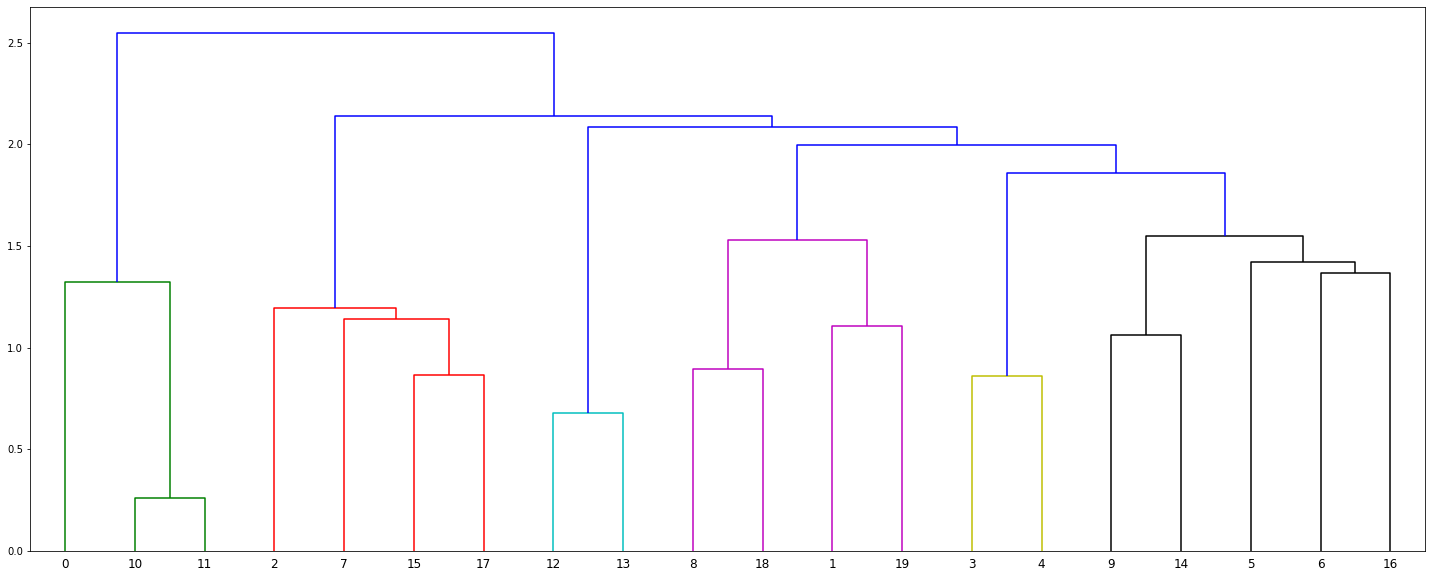

In [12]:
from scipy.cluster import hierarchy
# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = hierarchy.dendrogram(Z)
# Display this result as a horizontal dendrogram